In [2]:
import os
CODE_DIR = '/home/csp-uts/Hanyu/pixel2style2pixel-master/'
os.chdir(f'{CODE_DIR}')

from argparse import Namespace
import time
import os
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from numpy import linalg as LA

sys.path.append(".")
sys.path.append("..")

from scripts import id_loss_cal
from datasets import augmentations
from utils.common import tensor2im, log_input_image
from models.psp import pSp

%load_ext autoreload
%autoreload 2

# data path is a temporary path to save image generated in loop
data_path = CODE_DIR+'notebooks/results/ID_loss/Temp_loop/image_generated'
# gt path is a temporary path to save original image generated from latent code
gt_path = CODE_DIR+'notebooks/results/ID_loss/Temp_loop/image_groundtruth'
# image path is the path of original image
image_path = CODE_DIR+'notebooks/images/00000/00003.png'
# target image path is the path when using targeted mode
targeted_image_path = CODE_DIR+'notebooks/images/00000/00001.png'
# path image gen and path image gt is the path of temp image
path_image_gen = data_path+'/temp_image.png'
path_image_GT = gt_path+'/temp_image.png'
# latent avg path is the path of average latent, use it for untargeted mode
latent_avg_path = CODE_DIR+'notebooks/results/average_latent.npy'
latent_AVG = np.load(latent_avg_path)


experiment_type = 'ffhq_encode'

EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "pretrained_models/psp_ffhq_encode.pt",
        "image_path": "notebooks/images/input_img.jpg",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    }
}

EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]

model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
opts['checkpoint_path'] = model_path
pprint.pprint(opts)
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

{'batch_size': 8,
 'board_interval': 50,
 'checkpoint_path': 'pretrained_models/psp_ffhq_encode.pt',
 'dataset_type': 'ffhq_encode',
 'device': 'cuda:0',
 'encoder_type': 'GradualStyleEncoder',
 'exp_dir': '',
 'id_lambda': 0.1,
 'image_interval': 100,
 'input_nc': 3,
 'l2_lambda': 1.0,
 'l2_lambda_crop': 0,
 'label_nc': 0,
 'learn_in_w': False,
 'learning_rate': 0.0001,
 'lpips_lambda': 0.8,
 'lpips_lambda_crop': 0,
 'max_steps': 300000,
 'optim_name': 'ranger',
 'resize_factors': None,
 'save_interval': 1000,
 'start_from_latent_avg': True,
 'stylegan_weights': '',
 'test_batch_size': 8,
 'test_workers': 2,
 'train_decoder': False,
 'val_interval': 2500,
 'w_norm_lambda': 0,
 'workers': 8}
Loading pSp from checkpoint: pretrained_models/psp_ffhq_encode.pt
Model successfully loaded!


In [3]:
def run_on_batch(inputs, net):
    latent = []
    result_batch, latent,codes = net(inputs.to("cuda").float(), input_code=False, randomize_noise=False, return_latents=True)
    return result_batch, latent,codes

def run_on_gen(inputs, net):
    latent = []
    result_batch, latent,codes = net(inputs.to("cuda").float(), input_code=True, randomize_noise=False, return_latents=True)
    return result_batch, latent,codes

def hy_latent(latent_np):
#     hy_latent = torch.from_numpy(np.array([latent_np]))
    hy_latent = torch.from_numpy(latent_np)
    hy_latent = hy_latent.to('cuda').float()
    return hy_latent

def Image2Image_initial(image,targeted_image_path,path_img_gen,path_img_GT,latent_average,input_img_path=True,targeted=True):
    if input_img_path:
        image_path = image
        original_image = Image.open(image_path)
        original_image = original_image.convert("RGB")
        print('load image from:',image)
    else:
        original_image = image.convert("RGB")
        print('load image from Input image')
        
    img_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    transformed_image = img_transforms(original_image)

    with torch.no_grad():
        tic = time.time()
        result_image, latent,codes = run_on_batch(transformed_image.unsqueeze(0), net)
        toc = time.time()
        print('Generate original latent code took {:.4f} seconds.'.format(toc - tic))
        
    result_image.size()
    result_image = result_image[0]
    output_image = tensor2im(result_image)
    res_image = Image.fromarray(np.array(output_image.resize((256, 256))))
    plt.imshow(res_image)
    plt.axis('off')
    plt.title('Original Image')
    plt.show()
    res_image.save(path_img_GT)
    
    if targeted:
        print('select target image from:',targeted_image_path)
        generated_image = Image.open(targeted_image_path)
        generated_image = generated_image.convert("RGB")
        
        transformed_image_g = img_transforms(generated_image)
        
        with torch.no_grad():
            tic = time.time()
            result_image_g, latent_g,codes_g = run_on_batch(transformed_image_g.unsqueeze(0), net)
            toc = time.time()
            print('Generate targeted image latent code took {:.4f} seconds.'.format(toc - tic))
            
        result_image_g.size()
        result_image_g = result_image_g[0]
        output_image_g = tensor2im(result_image_g)
        res_image_g = Image.fromarray(np.array(output_image_g.resize((256, 256))))
        plt.imshow(res_image_g)
        plt.axis('off')
        plt.title('Targeted Image')
        plt.show()
        res_image_g.save(path_img_gen)
        
    else:
        print('untargeted mode use average latent code')
        
        latent_avg = latent_average
        latent2cuda = latent_avg
        latent_tensor = hy_latent(latent2cuda)
#         latent_tensor.shape
        
        with torch.no_grad():
            tic = time.time()
            result_image_g, latent_g,codes_g = run_on_gen(latent_tensor.unsqueeze(0), net)
            toc = time.time()
            print('Generate untargeted image from average latent code took {:.4f} seconds.'.format(toc - tic))
        
        result_image_g.size()
        result_image_g = result_image_g[0]
        output_image_g = tensor2im(result_image_g)
        res_image_g = Image.fromarray(np.array(output_image_g.resize((256, 256))))
        plt.imshow(res_image_g)
        plt.axis('off')
        plt.title('Untargeted Image')
        plt.show()
        res_image_g.save(path_img_gen)

    return codes,codes_g,path_img_GT,path_img_gen

def generate_latent_from_path(img_path,net):
    img_list = os.listdir(img_path)
    img_list.sort()
    len_img = len(img_list)
    img_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    
    latent_list = np.zeros([int(len_img),18,512])
    assert len_img!=0, "No image in folder"
    print(len_img,'images in folder!')
    
    for i in range(len_img):
        image_path = img_path+'/'+img_list[i]
        original_image = Image.open(image_path)
        original_image = original_image.convert("RGB")
        
        transformed_image = img_transforms(original_image)

        with torch.no_grad():
            result_image, latent,codes = run_on_batch(transformed_image.unsqueeze(0), net)
        
        latent_np = latent.cpu().detach().numpy()
        latent_list[i] = latent_np[0]
        if i+1 == len_img:
            percent = 100.0
            print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\n')
        else:
            percent = round(1.0*i/len_img*100,2)  
            print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\r')
    print('latent generation complete!')    
    return latent_list

# Fig 4

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
latent = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/latent_11k.npy')

In [6]:
latent_code = copy.copy(latent)

In [7]:
for j in range(len(latent_code)):
    if (latent_code[j]==np.zeros([18,512])).all():
        print(j)

63
121
385
743
938


In [8]:

latent_code = np.delete(latent_code,[63,121,385,743,938],axis=0)
print(latent_code.shape)

(10995, 18, 512)


In [25]:
latent_flat = latent_code.flatten()

In [26]:
latent_flat.shape

(101329920,)

/home/csp-uts/anaconda3/envs/Hanyu_psp/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


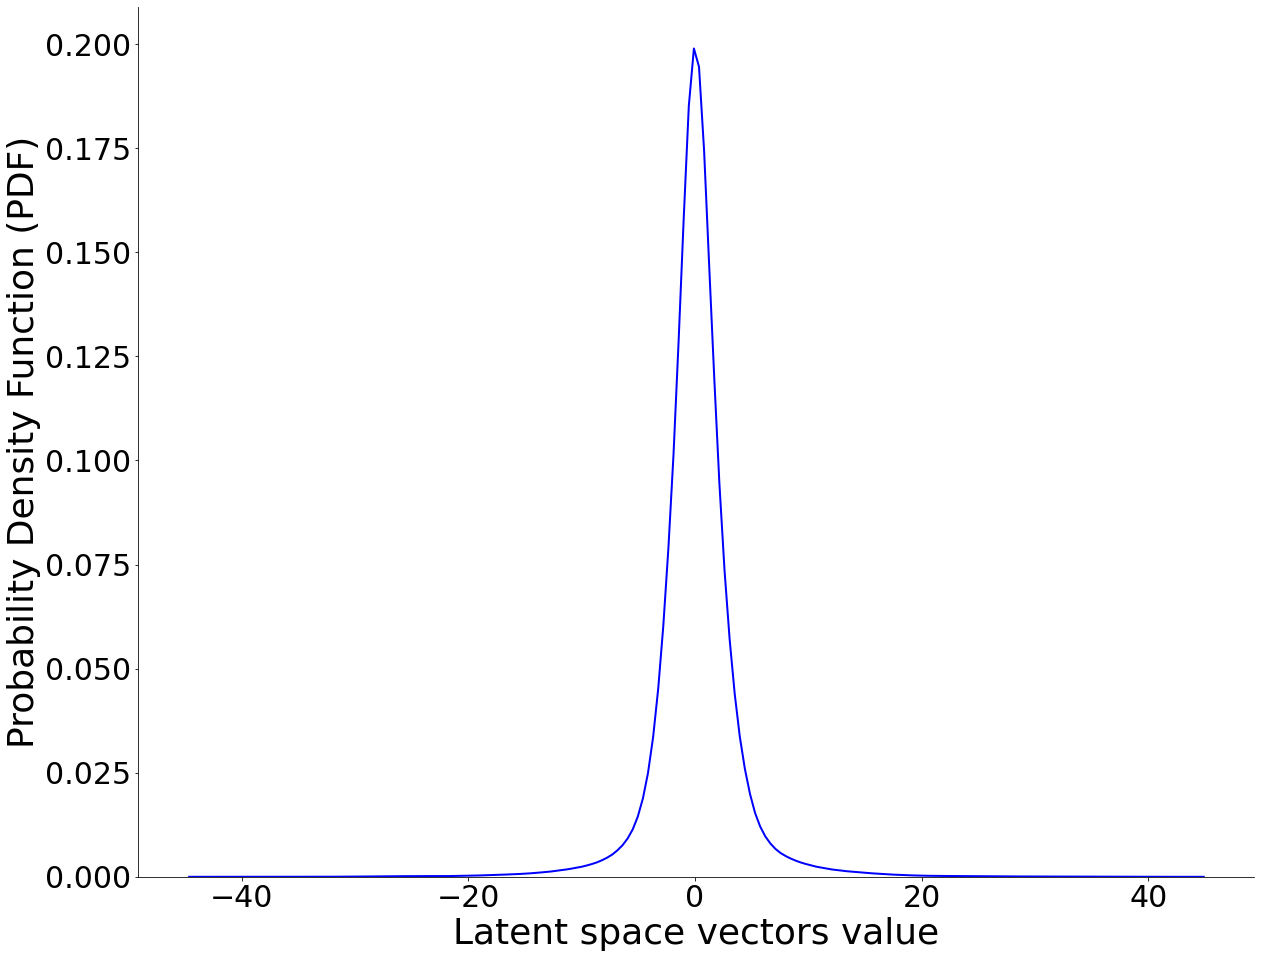

In [27]:
%matplotlib inline

figsize = 20,16
figure, ax = plt.subplots(figsize=figsize)

sns.distplot(latent_flat, hist=False, kde=True, 
            bins=int(180/5), color = 'blue',
            hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth':2})

# delete up,right axis
sns.despine()
#设置图例并且设置图例的字体及大小
# font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
# 'size'   : 23,
# }
# legend = plt.legend(handles=[A,B],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=30)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
 
#设置横纵坐标的名称以及对应字体格式
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 36,
}
plt.xlabel('Latent space vectors value',font2)
plt.ylabel('Probability Density Function (PDF)',font2)
 
#将文件保存至文件中并且画出图
plt.savefig('latent_vector_value.eps')
plt.show()


# Fig 5

## fig 5 (a)

In [28]:
# calculate l_p norm on all latent code
from numpy import linalg as LA
l_new = []
for x in range(len(latent_code)):
    for y in range(len(latent_code)):
        if y>x:
            c = (latent_code[x]-latent_code[y]).flatten()
            c_norm = LA.norm(c, ord=1)
            l_new.append(c_norm)
    if x+1 == len(latent_code):
        percent = 100.0
        print('Processing: %s [%d/%d]'%(str(percent)+'%',x+1,len(latent_code)),end='\n')
    else:
        percent = round(1.0*x/len(latent_code)*100,2)  
        print('Processing: %s [%d/%d]'%(str(percent)+'%',x+1,len(latent_code)),end='\r')


Processing: 100.0% [10995/10995]


In [29]:
np.save('l1_11k.npy',l_new)

In [33]:
len(l_new)

60439515

/home/csp-uts/anaconda3/envs/Hanyu_psp/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


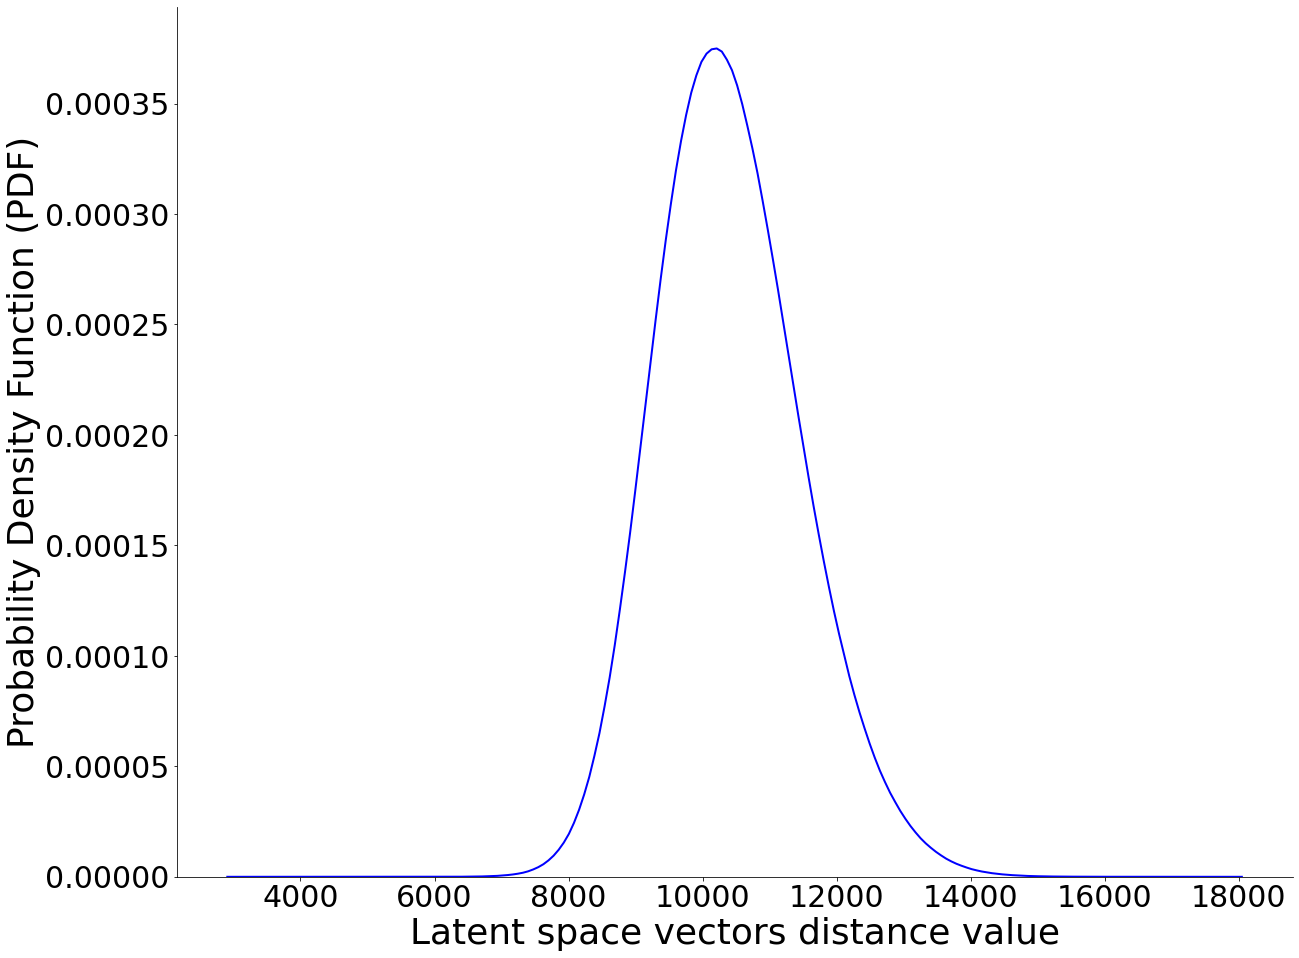

In [30]:
%matplotlib inline
l1_11k = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/l1_11k.npy')
figsize = 20,16
figure, ax = plt.subplots(figsize=figsize)

sns.distplot(l1_11k, hist=False, kde=True, 
            bins=int(180/5), color = 'blue',
            hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth':2})

# delete up,right axis
sns.despine()
#设置图例并且设置图例的字体及大小
# font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
# 'size'   : 23,
# }
# legend = plt.legend(handles=[A,B],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=30)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
 
#设置横纵坐标的名称以及对应字体格式
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 36,
}
plt.xlabel('Latent space vectors distance value',font2)
plt.ylabel('Probability Density Function (PDF)',font2)
 
#将文件保存至文件中并且画出图
plt.savefig('latent_vector_distance_value_11k.eps')
plt.show()

In [21]:
l1_11k = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/l1_11k.npy')
aaa = l1_11k>17900
print(l1_11k[aaa])
for i in range(len(aaa)):
    if aaa[i]==True:
        print(i)
        


[17954.82739322]
17154323


In [489]:
l1_11k = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/l1_11k.npy')

In [3]:
count = 0
for i in range(10995):
    for j in range(10995):
        if j>i:
            count = count+1
            if count==17154323:
                print(i,j,count)

1690 3358 17154323


In [490]:
np.min(l1_11k)

2998.025016298052

In [5]:
3358-995

2363

In [35]:
a = np.array([1,-1,2,-2,-5.5])
LA.norm(a, ord=1)

11.5

In [36]:
# calculate l_p norm on seperate latent code
from numpy import linalg as LA
l_new_low = []
for x in range(len(latent_code)):
    for y in range(len(latent_code)):
        if y>x:
            c_low = (latent_code[x][0:7,:]-latent_code[y][0:7,:]).flatten()
            c_norm_low = LA.norm(c_low, ord=1)
            l_new_low.append(c_norm_low)
    if x+1 == len(latent_code):
        percent = 100.0
        print('Processing: %s [%d/%d]'%(str(percent)+'%',x+1,len(latent_code)),end='\n')
    else:
        percent = round(1.0*x/len(latent_code)*100,2)  
        print('Processing: %s [%d/%d]'%(str(percent)+'%',x+1,len(latent_code)),end='\r')


Processing: 100.0% [10995/10995]


In [37]:
np.save('l1_low_11k.npy',l_new_low)

/home/csp-uts/anaconda3/envs/Hanyu_psp/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


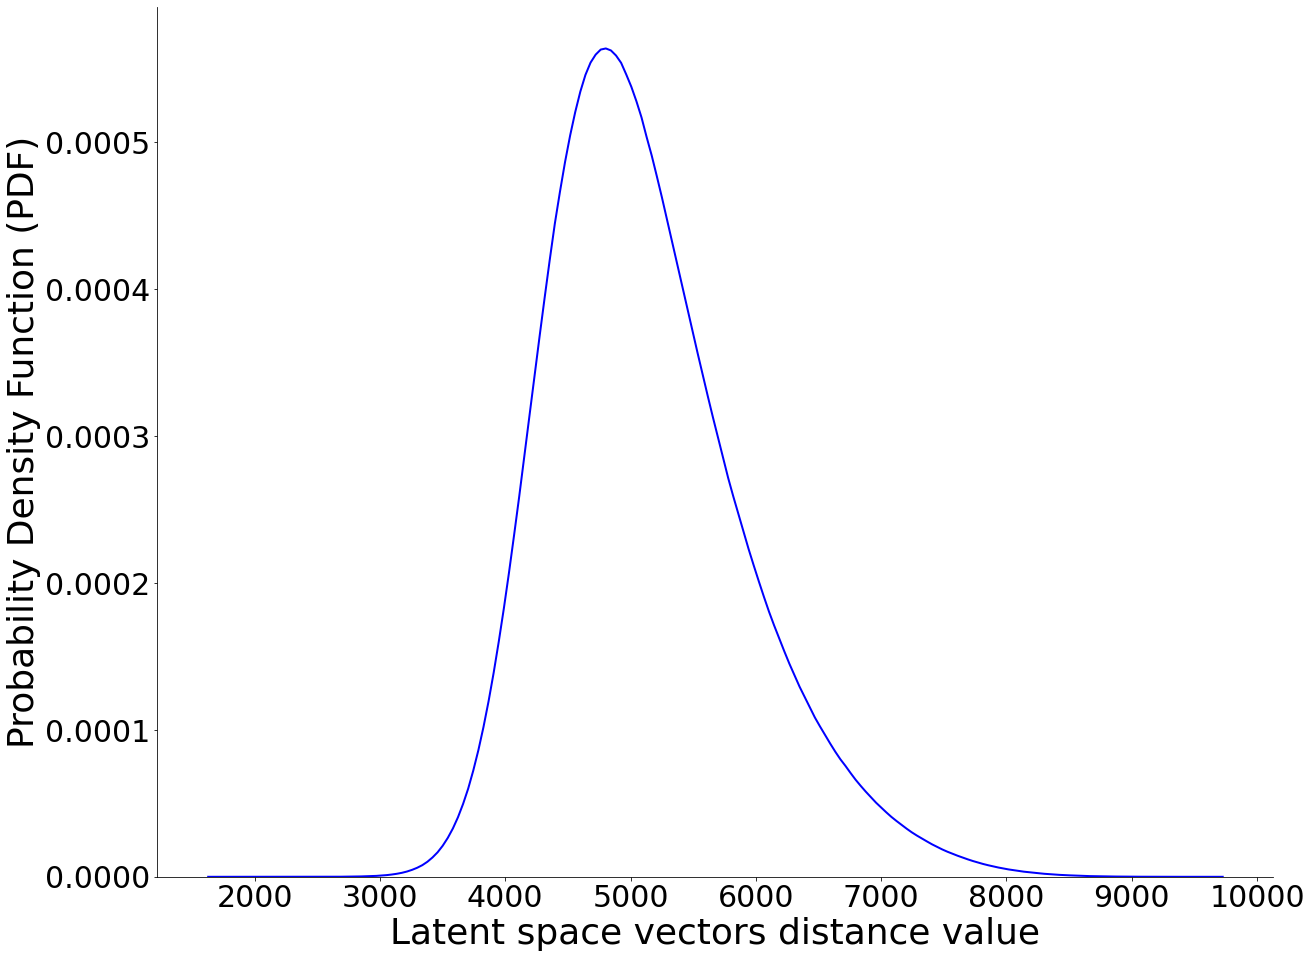

In [39]:
%matplotlib inline
l1_11k_low = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/l1_low_11k.npy')
figsize = 20,16
figure, ax = plt.subplots(figsize=figsize)

sns.distplot(l1_11k_low, hist=False, kde=True, 
            bins=int(180/5), color = 'blue',
            hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth':2})

# delete up,right axis
sns.despine()
#设置图例并且设置图例的字体及大小
# font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
# 'size'   : 23,
# }
# legend = plt.legend(handles=[A,B],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=30)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
 
#设置横纵坐标的名称以及对应字体格式
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 36,
}
plt.xlabel('Latent space vectors distance value',font2)
plt.ylabel('Probability Density Function (PDF)',font2)
 
#将文件保存至文件中并且画出图
plt.savefig('latent_vector_distance_value_11k_low.eps')
plt.show()

In [512]:
l1_11k_low = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/l1_low_11k.npy')
np.max(l1_11k_low)

9660.186586143449

## fig 5 (b)

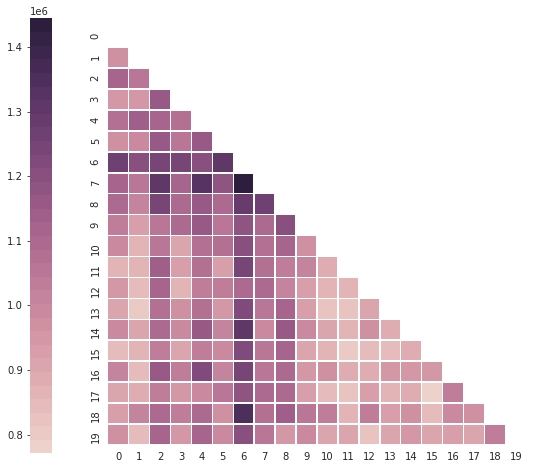

In [2]:
# to plot the 20*20 distance heat map
import numpy as np
from copy import deepcopy
import os
import seaborn as sns
from numpy.random import randn
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from numpy import linalg as LA

Image_vector = [1,2,4,5,6,8,112,9,943,11,12,686,15,16,17,18,19,703,20,21]
Map_mat = np.zeros([len(Image_vector),len(Image_vector)])
latent = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/latent_11k.npy')

for i in range(len(Image_vector)):
    for j in range(len(Image_vector)):
        index1 = Image_vector[i]
        index2 = Image_vector[j]
        sub_temp = (latent[index1]-latent[index2]).flatten()
        l1_temp = LA.norm(sub_temp,ord=1)
        Map_mat[i,j]= l1_temp

mask = np.zeros_like(Map_mat)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10, 8))
with sns.axes_style("white"):
    ax = sns.heatmap((Map_mat*100).astype(np.int),mask=mask,cmap=sns.cubehelix_palette(32),cbar_kws={"use_gridspec":False,"location":"left"},linewidths=.5,square=True,annot=False, fmt="d")
plt.savefig('latent_vector_distance_heatmap_20.eps')
plt.show()    


In [493]:
sub_temp = (latent[112]-latent[9]).flatten()
l1_temp = LA.norm(sub_temp,ord=1)

In [494]:
l1_temp

14445.854465712793

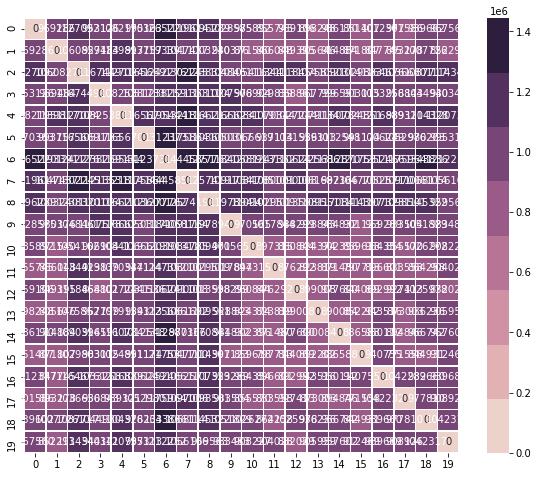

In [41]:
plt.figure(figsize=(10, 8))
sns.heatmap((Map_mat*100).astype(np.int),cmap=sns.cubehelix_palette(8),linewidths=.5,square=True,annot=True, fmt="d")

# Fig 8&9

In [17]:
import requests
import json
import http.client, urllib.request, urllib.parse, urllib.error, base64

def find_faceID(image_path):
    # set to your own subscription key value
    subscription_key = '22bc414df66a4c6ca7979c7f1963c64e'
#     subscription_key = '07360b08ae7e4da9896e9a59e5cc3d68'

    assert subscription_key

    face_api_url = 'https://australiaeast.api.cognitive.microsoft.com/face/v1.0/detect'

    # image_url = 'https://upload.wikimedia.org/wikipedia/commons/3/37/Dagestani_man_and_woman.jpg'
    # Set image_path to the local path of an image that you want to analyze.
    image_path = image_path

    # Read the image into a byte array
    image_data = open(image_path, "rb").read()

    headers = {
      'Content-Type': 'application/octet-stream',
      'Ocp-Apim-Subscription-Key': subscription_key}

    params = {
      'returnFaceId': 'true',
      'returnFaceLandmarks': 'false',
      # 'returnFaceAttributes': 'age,gender,headPose,smile,facialHair,glasses,emotion,hair,makeup,occlusion,accessories,blur,exposure,noise',
    }

    response = requests.post(face_api_url, params=params,
                          headers=headers, data=image_data)
    if type(response.json()) is list:
        if len(response.json()) != 0:
            faceId = response.json()[0]['faceId']
        else:
            faceId = '1d083ffc-a2a9-436f-8e84-4395ec17fcfb'
    else:
        faceId = '1d083ffc-a2a9-436f-8e84-4395ec17fcfb'
    # print(json.dumps(response.json()))
    # print(response.json()[0]['faceId'])
    return faceId


def isIdenticalll(faceid1,faceid2):
    '''
    This function verify the two face are same or not,
    faceid1: str, the id of face to be test,
    faceid2: str, the id of face original.
    '''
    subscription_key = '22bc414df66a4c6ca7979c7f1963c64e'
#     subscription_key = '07360b08ae7e4da9896e9a59e5cc3d68'
    assert subscription_key

    face_api_url = 'https://australiaeast.api.cognitive.microsoft.com/face/v1.0/verify'

    headers = {
      # Request headers
      'Content-Type': 'application/json',
      'Ocp-Apim-Subscription-Key': subscription_key,
    }

    params = {
      "faceId1": faceid1,
      "faceId2": faceid2,
    }

    body = json.dumps(params)

    import requests
    from pprint import pprint
    response  = requests.post(face_api_url, headers=headers,data=body)
    result = response.json()
    # confi = result['confidence']
    # isId = result['isIdentical']
    # pprint(result['confidence'])
    # pprint(result['isIdentical'])
    return result

In [5]:
def gen_lap_noise(delta_f,loc=0,epsilon=4):
    #This function returns the laplace random noise.
    '''
    loc, epsilon: the coefficients of Laplace tranform (e.g. laplace(loc,delta_f/epsilon))
    '''
    # r = deepcopy(delta_f_list)
    # r[img_pick,img_pick]=np.inf
    # delta_f = np.min(r[img_pick,:])
    scale = delta_f/epsilon
    s = np.random.laplace(loc, scale, [18,512])
    return s

In [16]:
latent = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/latent_11k.npy')
latent_code = copy.copy(latent)
latent_code = np.delete(latent_code,[63,121,385,743,938],axis=0)
print(latent_code.shape)

(10995, 18, 512)


## generate DP noise for all layers

In [1265]:
gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/images/00000/00265.png'
gt_image = Image.open(gt_path)
gt_image = gt_image.convert("RGB")

faceId2 = find_faceID(gt_path)
print(faceId2)

710e7b42-6672-4fa8-ace9-f5e69014f902


0.4695037305355072


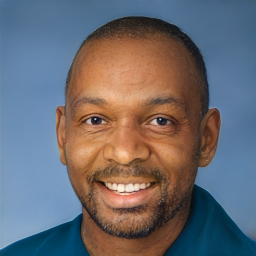

In [1472]:
delta_F = 17955
epsilon = delta_F*4
dp_noise = gen_lap_noise(delta_F,0,epsilon)

latent_gt = latent_code[263]
latent_dp = latent_gt+dp_noise
input_latent = hy_latent(latent_dp)

with torch.no_grad():
    result_image_temp, latent_temp,codes_temp = run_on_gen(input_latent.unsqueeze(0), net)
    
result_image_temp = result_image_temp[0]
output_image_temp = tensor2im(result_image_temp)
# res_image_temp = Image.fromarray(np.array(output_image_temp))
res_image_temp = Image.fromarray(np.array(output_image_temp.resize((256, 256))))
score_temp = id_loss_cal.extract_on_images(gt_image,res_image_temp,gt_path)
ID_score = score_temp['00265.png']

print(ID_score)
res_image_temp

In [1473]:
res_image_temp.save('00265_dp_epsilon_4_df.png')

In [1474]:
Gener_path = '00265_dp_epsilon_4_df.png'
faceId1 = find_faceID(Gener_path)
print(faceId1)

db84b320-6593-4a46-8d08-e83831071172


In [1475]:
re = isIdenticalll(faceId1,faceId2)
print(re)

{'isIdentical': True, 'confidence': 0.73617}


## generate DP noise for identity layers

0.43356597423553467


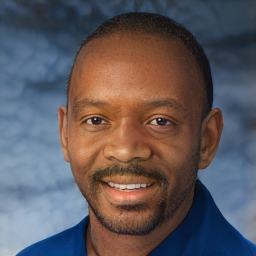

In [1658]:
gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/images/00000/00265.png'
gt_image = Image.open(gt_path)
gt_image = gt_image.convert("RGB")

delta_F = 17955
epsilon = 9660*4
dp_noise = gen_lap_noise(delta_F,0,epsilon)
mask = np.zeros_like(dp_noise)
mask[0:7,:] = 1

latent_gt = latent_code[263]
latent_dp = latent_gt+dp_noise*mask
input_latent = hy_latent(latent_dp)

with torch.no_grad():
    result_image_temp, latent_temp,codes_temp = run_on_gen(input_latent.unsqueeze(0), net)
    
result_image_temp = result_image_temp[0]
output_image_temp = tensor2im(result_image_temp)
res_image_temp = Image.fromarray(np.array(output_image_temp.resize((256, 256))))
score_temp = id_loss_cal.extract_on_images(gt_image,res_image_temp,gt_path)
ID_score = score_temp['00265.png']

print(ID_score)
res_image_temp

In [1659]:
res_image_temp.save('00265_local_dp_epsilon_4_df.png')

In [1660]:
Gener_path = '00265_local_dp_epsilon_4_df.png'
faceId1 = find_faceID(Gener_path)
print(faceId1)

7ba75581-295c-47f3-bca3-1e7c6ee1d5f3


In [1661]:
re = isIdenticalll(faceId1,faceId2)
print(re)

{'isIdentical': True, 'confidence': 0.70587}


# Fig 10

# Fig 11

In [467]:
image_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/images/image_all'

In [474]:
img_list = os.listdir(image_path)
img_list.sort()

In [475]:
img_list

['00000.png',
 '00001.png',
 '00002.png',
 '00003.png',
 '00004.png',
 '00005.png',
 '00006.png',
 '00007.png',
 '00008.png',
 '00009.png',
 '00010.png',
 '00011.png',
 '00012.png',
 '00013.png',
 '00014.png',
 '00015.png',
 '00016.png',
 '00017.png',
 '00018.png',
 '00019.png',
 '00020.png',
 '00021.png',
 '00022.png',
 '00023.png',
 '00024.png',
 '00025.png',
 '00026.png',
 '00027.png',
 '00028.png',
 '00029.png',
 '00030.png',
 '00031.png',
 '00032.png',
 '00033.png',
 '00034.png',
 '00035.png',
 '00036.png',
 '00037.png',
 '00038.png',
 '00039.png',
 '00040.png',
 '00041.png',
 '00042.png',
 '00043.png',
 '00044.png',
 '00045.png',
 '00046.png',
 '00047.png',
 '00048.png',
 '00049.png',
 '00050.png',
 '00051.png',
 '00052.png',
 '00053.png',
 '00054.png',
 '00055.png',
 '00056.png',
 '00057.png',
 '00058.png',
 '00059.png',
 '00060.png',
 '00061.png',
 '00062.png',
 '00064.png',
 '00065.png',
 '00066.png',
 '00067.png',
 '00068.png',
 '00069.png',
 '00070.png',
 '00071.png',
 '0007

In [470]:
len_img = len(img_list)
print('There are %d images in folder!'%len_img)

There are 10995 images in folder!


In [473]:
len_code = len(latent_code)
print('There are %d image latent vector!'%len_code)

There are 10995 image latent vector!


In [478]:
delta_F = 17955
epsilon = delta_F
temp_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/confidence_curve_temp_image_path/00001.jpg' 
# a temporary path to store generated img
P_temp = []
for i in range(len_img):
    gt_image_path_temp = image_path+'/'+img_list[i]
    faceId2 = find_faceID(gt_image_path_temp)
    
    gt_latent_temp = latent_code[i]
    dp_noise = gen_lap_noise(delta_F,0,epsilon)
    latent_dp_temp = gt_latent_temp+dp_noise
    input_latent = hy_latent(latent_dp_temp)
    
    with torch.no_grad():
        result_image_temp, latent_temp,codes_temp = run_on_gen(input_latent.unsqueeze(0), net)
    
    result_image_temp = result_image_temp[0]
    output_image_temp = tensor2im(result_image_temp)
    res_image_temp = Image.fromarray(np.array(output_image_temp.resize((256, 256))))
    res_image_temp.save(temp_path)
    faceId1 = find_faceID(temp_path)
    result = isIdenticalll(faceid1=faceId1,faceid2=faceId2)
    if not 'isIdentical' in result.keys():
        P_temp.append(0)
    else:
        P_temp.append(result['confidence'])

    if i+1 == len_img:
        percent = 100.0
        print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\n')
    else:
        percent = round(1.0*i/len_img*100,2)  
        print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\r')

KeyboardInterrupt: 

In [ ]:
np.save('confi_deltaf_1_epsilon_all_layer.npy',P_temp)

In [101]:
def confi_curve(gt_img_path,latent_code,delta_f,epsilon):
    delta_F = delta_f
    epsilon = epsilon
    img_list = os.listdir(gt_img_path)
    img_list.sort()
    len_img = len(img_list)
    len_code = len(latent_code)
    temp_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/confidence_curve_temp_image_path/00001.jpg' 
    # a temporary path to store generated img
    P_temp = []
    for i in range(len_img):
        gt_image_path_temp = gt_img_path+'/'+img_list[i]
        faceId2 = find_faceID(gt_image_path_temp)

        gt_latent_temp = latent_code[i]
        dp_noise = gen_lap_noise(delta_F,0,epsilon)
        latent_dp_temp = gt_latent_temp+dp_noise
        input_latent = hy_latent(latent_dp_temp)

        with torch.no_grad():
            result_image_temp, latent_temp,codes_temp = run_on_gen(input_latent.unsqueeze(0), net)

        result_image_temp = result_image_temp[0]
        output_image_temp = tensor2im(result_image_temp)
        res_image_temp = Image.fromarray(np.array(output_image_temp.resize((256, 256))))
        res_image_temp.save(temp_path)
        faceId1 = find_faceID(temp_path)
        result = isIdenticalll(faceid1=faceId1,faceid2=faceId2)
        if not 'isIdentical' in result.keys():
            P_temp.append(0)
        else:
            P_temp.append(result['confidence'])

        if i+1 == len_img:
            percent = 100.0
            print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\n')
        else:
            percent = round(1.0*i/len_img*100,2)  
            print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\r')
            
    return P_temp

In [26]:
scale_index = [2]
delta_f = 17955
gt_img_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/images/image_all'
for i in scale_index:
    epsilon = delta_f*i
    print('scale set to:',i)
    print('* '*10)
    j = str(int(i*10))
    Confi_vector = confi_curve(gt_img_path,latent_code,delta_f,epsilon)
    p_mean = np.mean(Confi_vector)
    print('Average confidence:',p_mean)
    save_name = 'confi_deltaf_'+j+'_epsilon_all_layer.npy'
    np.save(save_name,Confi_vector)

scale set to: 2
* * * * * * * * * * 
Processing: 100.0% [10995/10995]
Average confidence: 0.5954649622555707


In [27]:
scale_index = [2.5]
delta_f = 17955
gt_img_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/images/image_all'
for i in scale_index:
    epsilon = delta_f*i
    print('scale set to:',i)
    print('* '*10)
    j = str(int(i*10))
    Confi_vector = confi_curve(gt_img_path,latent_code,delta_f,epsilon)
    p_mean = np.mean(Confi_vector)
    print('Average confidence:',p_mean)
    save_name = 'confi_deltaf_'+j+'_epsilon_all_layer.npy'
    np.save(save_name,Confi_vector)

scale set to: 2.5
* * * * * * * * * * 
Processing: 100.0% [10995/10995]
Average confidence: 0.6749050150068213


In [106]:
scale_index = [5]
delta_f = 17955
gt_img_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/images/blur_test'
for i in scale_index:
    epsilon = delta_f*i
    print('scale set to:',i)
    print('* '*10)
    j = str(int(i*10))
    Confi_vector = confi_curve(gt_img_path,latent_code,delta_f,epsilon)
    p_mean = np.mean(Confi_vector)
    print('Average confidence:',p_mean)
    save_name = 'confi_deltaf_'+j+'_epsilon_all_layer.npy'
#     np.save(save_name,Confi_vector)

scale set to: 5
* * * * * * * * * * 
Processing: 100.0% [100/100]
Average confidence: 0.7807839999999999


In [97]:
confi_1 = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/confidence_table/confi_deltaf_10_epsilon_all_layer.npy')
confi_2 = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/confidence_table/confi_deltaf_15_epsilon_all_layer.npy')
confi_3 = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/confidence_table/confi_deltaf_20_epsilon_all_layer.npy')
confi_4 = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/confidence_table/confi_deltaf_25_epsilon_all_layer.npy')
confi_5 = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/confidence_table/confi_deltaf_30_epsilon_all_layer.npy')

In [98]:
p_1 = np.mean(confi_1)
p_2 = np.mean(confi_2)
p_3 = np.mean(confi_3)
p_4 = np.mean(confi_4)
p_5 = np.mean(confi_5)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


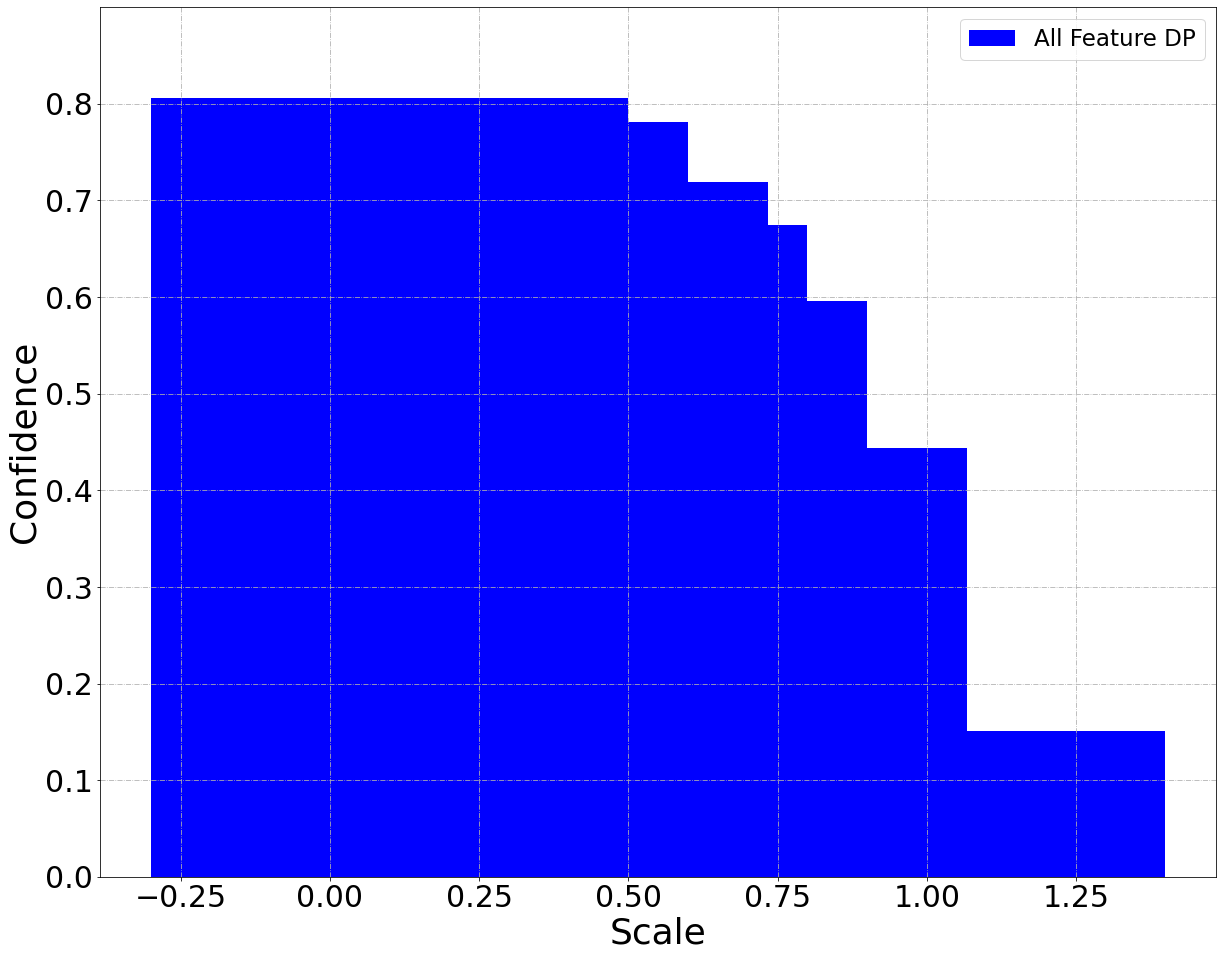

In [496]:
%matplotlib inline
sc = [1,1/1.5,1/2,1/2.5,1/3,0.2,0.1]
p = [p_1,p_2,p_3,p_4,p_5,0.7807839999999999,0.8055274]
sc2 = [1,9660/delta_f,9660/(1.5*delta_f),9660/(2*delta_f),9660/(2.5*delta_f),9660/(3*delta_f),0.1]
# sc2 = [delta_f/9660,(1.5*delta_f)/9660,(2*delta_f)/9660,(2.5*delta_f)/9660,(3*delta_f)/9660]

figsize = 20,16
figure, ax = plt.subplots(figsize=figsize)


plt.plot(sc,p,color = 'blue', linewidth=2)
plt.plot(sc2,p2,color = 'darkred', linewidth=2)

# 设置图例并且设置图例的字体及大小
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 23,
}
legend = plt.legend(["All Feature DP","Identity Feature DP"],prop=font1)

#set axe limit and ticks
plt.ylim((0,0.9))
plt.yticks(np.arange(0,0.9,0.1))

ax.grid(True,linestyle='-.')

#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=30)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
 
#设置横纵坐标的名称以及对应字体格式
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 36,
}
plt.xlabel('Scale',font2)
plt.ylabel('Confidence',font2)
 
#将文件保存至文件中并且画出图
plt.savefig('Noise_2_Confi.eps')
plt.show()

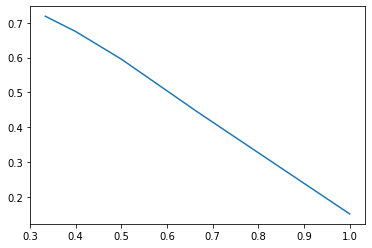

In [39]:
%matplotlib inline
sc = [1,1/1.5,1/2,1/2.5,1/3]
p = [p_1,p_2,p_3,p_4,p_5]

fig = plt.figure()
plt.plot(sc,p)
plt.show()

In [84]:
def confi_curve_identity(gt_img_path,latent_code,delta_f,epsilon):
    delta_F = delta_f
    epsilon = epsilon
    img_list = os.listdir(gt_img_path)
    img_list.sort()
    len_img = len(img_list)
    len_code = len(latent_code)
    temp_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/confidence_curve_temp_image_path/00001.jpg' 
    # a temporary path to store generated img
    P_temp = []
    for i in range(len_img):
        gt_image_path_temp = gt_img_path+'/'+img_list[i]
        faceId2 = find_faceID(gt_image_path_temp)

        gt_latent_temp = latent_code[i]
        dp_noise = gen_lap_noise(delta_F,0,epsilon)
        dp_noise[7:18,:] = 0
        latent_dp_temp = gt_latent_temp+dp_noise
        input_latent = hy_latent(latent_dp_temp)

        with torch.no_grad():
            result_image_temp, latent_temp,codes_temp = run_on_gen(input_latent.unsqueeze(0), net)

        result_image_temp = result_image_temp[0]
        output_image_temp = tensor2im(result_image_temp)
        res_image_temp = Image.fromarray(np.array(output_image_temp.resize((256, 256))))
        res_image_temp.save(temp_path)
        faceId1 = find_faceID(temp_path)
        result = isIdenticalll(faceid1=faceId1,faceid2=faceId2)
        if not 'isIdentical' in result.keys():
            P_temp.append(0)
        else:
            P_temp.append(result['confidence'])

        if i+1 == len_img:
            percent = 100.0
            print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\n')
        else:
            percent = round(1.0*i/len_img*100,2)  
            print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\r')
            
    return P_temp

In [104]:
scale_index = [5.36815782]
delta_f = 17995
gt_img_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/images/blur_test'
for i in scale_index:
    epsilon = delta_f*i
    print('* '*10)
    print('scale set to:',i)
    j = str(int(i*10))
    Confi_vector = confi_curve_identity(gt_img_path,latent_code,delta_f,epsilon)
    p_mean = np.mean(Confi_vector)
    print('Average confidence:',p_mean)
    save_name = 'confi_deltaf_'+j+'_epsilon_id_layer.npy'
#     np.save(save_name,Confi_vector)

* * * * * * * * * * 
scale set to: 5.36815782
Processing: 100.0% [100/100]
Average confidence: 0.7999176


In [89]:
0.8002141

9660.0

In [102]:
p2 = [0.0596272,0.4357748140703518,0.6354548743718593,0.7069204924623116,0.7466345025125628,0.7712548442211056,0.8002141]

In [523]:
p_2

0.4436997744429287

In [530]:
(p_3-p_2)*((1/1.5-0.6)/(1/1.5-0.5))+p_2

0.5044058495679855

# Fig 9&10

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


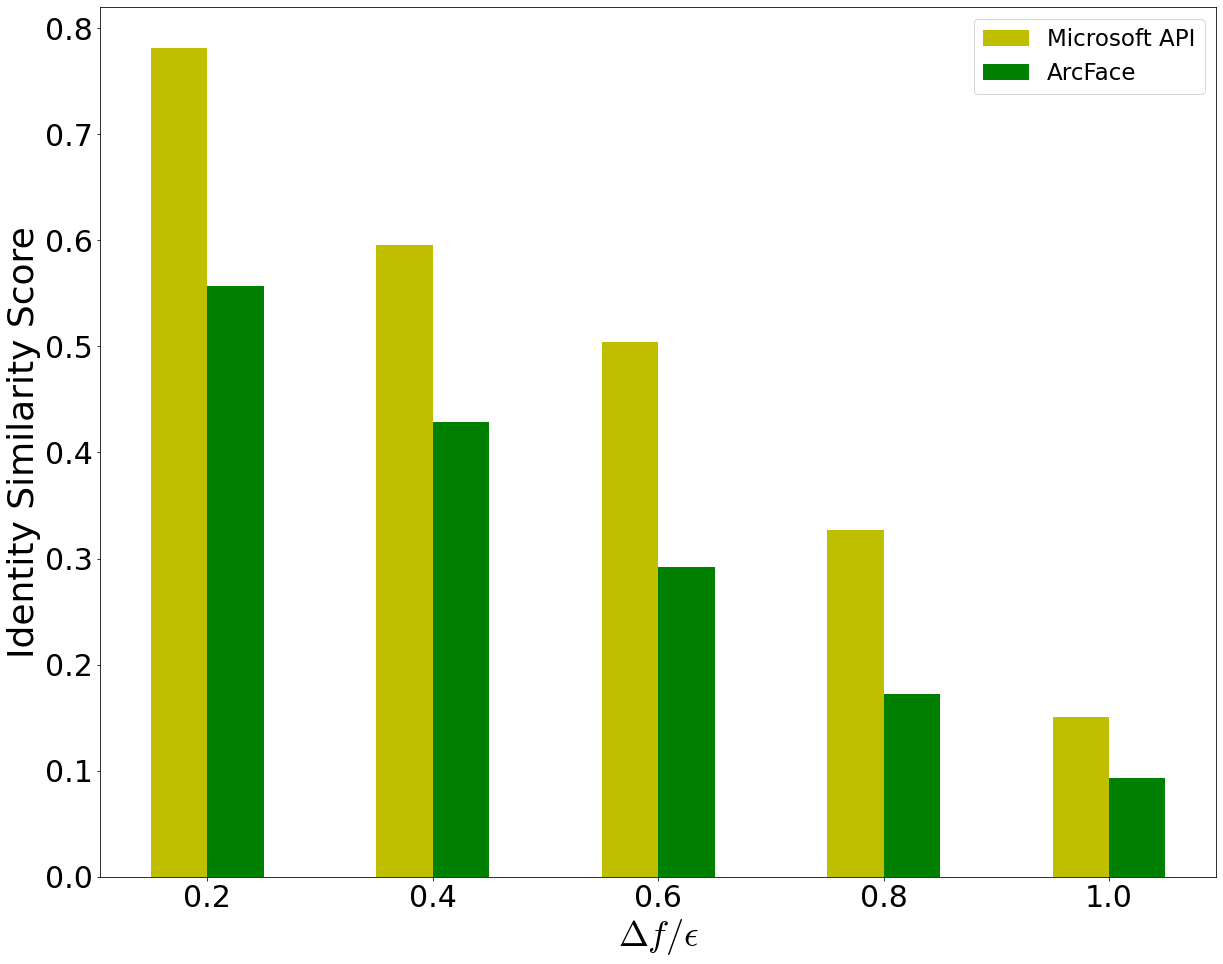

In [652]:
import matplotlib.pyplot as plt
%matplotlib inline

width = 0.05
sc = np.array([0.2,0.4,0.6,0.8,1])
sc1 = sc-width/2
sc2 = sc+width/2
p_ms = [0.7807839999999999,p_3,0.5044058495679855,0.3264452674852205,p_1]
p_arc = [0.556976258322297,0.42839423125310233,0.2923312855013439,0.1727654908808493,0.09337350243593083]


figsize = 20,16
plt.rcParams["mathtext.fontset"] = "cm"
figure, ax = plt.subplots(figsize=figsize)
plt.bar(sc1, p_ms, width=width,fc = 'y')
plt.bar(sc2, p_arc, width=width,fc = 'g')

font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 23,
}
legend = plt.legend(["Microsoft API","ArcFace"],prop=font1)

#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=30)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
 
#设置横纵坐标的名称以及对应字体格式
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 36,
}
plt.xlabel('$\Delta f/\epsilon$',font2)
plt.ylabel('Identity Similarity Score',font2)
plt.savefig('Noise_2_ISS.eps')
plt.show()

In [600]:
all_confi_10 = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/confidence_table/confi_deltaf_10_epsilon_all_layer.npy')
all_confi_15 = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/confidence_table/confi_deltaf_15_epsilon_all_layer.npy')
all_confi_20 = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/confidence_table/confi_deltaf_20_epsilon_all_layer.npy')
all_confi_25 = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/confidence_table/confi_deltaf_25_epsilon_all_layer.npy')
all_confi_30 = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/confidence_table/confi_deltaf_30_epsilon_all_layer.npy')

In [618]:
np.shape(np.array(np.where(all_confi_15>0.5)))

(1, 4768)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


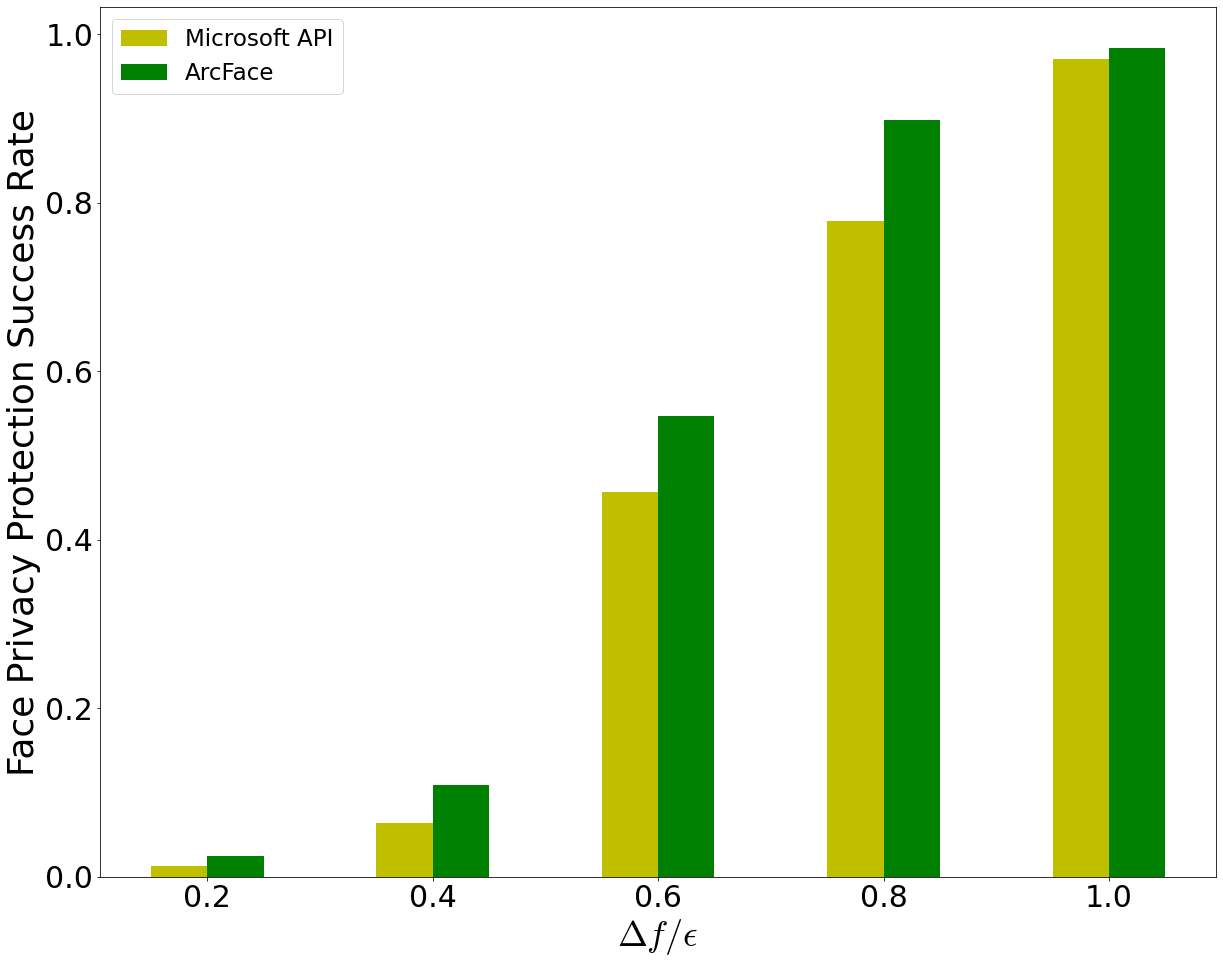

In [651]:

import matplotlib.pyplot as plt
%matplotlib inline

width = 0.05

noise_scale = [1,0.8,0.6,0.4,0.2]
ns1 = np.array(noise_scale)-width/2
ns2 = np.array(noise_scale)+width/2
sr_ms = [0.9705320600272851, 0.7780218281036837, 0.4568212824010914, 0.06429286039108682, 0.012551159618008123]
sr_arc = [978/995,894/995,544/995,108/995,24/995]

figsize = 20,16
plt.rcParams["mathtext.fontset"] = "cm"
figure, ax = plt.subplots(figsize=figsize)
plt.bar(ns1, sr_ms, width=width,fc = 'y')
plt.bar(ns2, sr_arc, width=width,fc = 'g')

font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 23,
}
legend = plt.legend(["Microsoft API","ArcFace"],prop=font1)

#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=30)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
 
#设置横纵坐标的名称以及对应字体格式
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 36,
}
plt.xlabel('$\Delta f/\epsilon$',font2)
plt.ylabel('Face Privacy Protection Success Rate',font2)
plt.savefig('Noise_2_FPPSR.eps')
plt.show()

# Table

|                     | L2  | ALD_P | SSIM | FID | Microsoft API | Facenet | ArcFace |
|:-------------------:|:---:|:-----:|:----:|:---:|:-------------:|:-------:|:-------:|
|         Blur16      |71892.60345829872|1.1338183401018107|0.6197678076232997|231.99746601679917|~0.5|0.9387628|0.4292421043817721|
|        Mosaic9      |71060.10270686568|1.1484423010404063|0.5535271769069017|383.1714267877878|~0.5|1.0803185|0.2576537167962322|
|    All feature DP   |68071.27077274685|1.2214458048893801|0.38764926501447444|219.85579932762968|~0.5|0.84939146|0.2958990856527758|
| Identity feature DP |71025.74681434128|1.2312498565427172|0.4795445031088839|162.82165549121473|~0.5|0.60118335|0.48053201250638344|


# Table

|                     | L2  | ALD_P | SSIM | FID | Microsoft API | Facenet | ArcFace |
|:-------------------:|:---:|:-----:|:----:|:---:|:-------------:|:-------:|:-------:|
|         Blur16      |71782.96062000905|1.1501792214184152|0.5894969394741129|265.75790088325573|0.42829|1.0321873|0.3144314147045265|
|        Mosaic9      |70438.7981720381|1.1385557530500228|0.5705463506597979|377.524502559265|0.49045|1.0572731|0.3126681283944703|
|    All feature DP   |68071.27077274685|1.2214458048893801|0.38764926501447444|219.85579932762968|0.45497|0.84939146|0.2958990856527758|
| Identity feature DP |68194.39336970555|1.2159533059412937|0.3985172774732106|204.7182394402078|0.49609|0.8188843|0.29751966281527253|


In [ ]:
L2: 69817.49363721051
aldp: 1.1286692050596392
ssim: 0.587565524412694
arcface: 0.36768253999270833
fid: 371.87757833074215
facenet: 1.0342277


In [484]:
np.mean([1.0342277,1.0803185])

1.0572731

In [464]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import random
import copy
from skimage.metrics import structural_similarity as ssim
from numpy import linalg as LA
# from pytorch_fid import fid_score
from fid_score.fid_score import FidScore
from facenet_pytorch import MTCNN, InceptionResnetV1

resnet = InceptionResnetV1(pretrained='vggface2').eval()
mtcnn = MTCNN(image_size=256, margin=80)
sys.path.append("/home/csp-uts/Hanyu/facenet/src")
from face_ID_loss import load_and_align_data,clac_loss
import facenet

img_transforms = EXPERIMENT_ARGS['transform']
def hy_blur(img,blur_size):
    blur = cv2.blur(img,(blur_size,blur_size))
    return blur

def hy_mosaic(image,size):
    img = copy.copy(image)
    x,y,_ = img.shape
    for i in range(0,x-size,size):
        for j in range(0,y-size,size):
            img[i:i+size,j:j+size] = img[i+(size//2)][j+(size//2)]
    return img

            
def hy_L2(img,img_noise):
    a = img-img_noise
    b = a.flatten()
    L2_score = LA.norm(b)
    return L2_score

def hy_ALDp(img,img_noise):
    a = copy.copy(img)
    b = copy.copy(img_noise)
    c = a-b
    a1 = LA.norm(c[:,:,0], ord=np.inf)/LA.norm(a[:,:,0], ord=np.inf)
    a2 = LA.norm(c[:,:,1], ord=np.inf)/LA.norm(a[:,:,1], ord=np.inf)
    a3 = LA.norm(c[:,:,2], ord=np.inf)/LA.norm(a[:,:,2], ord=np.inf)
    ALDp_score = np.mean([a1,a2,a3])
    return ALDp_score
    
def hy_SSIM(img,img_noise):
    ssim_noise = ssim(img, img_noise,multichannel=True)
    return ssim_noise

def hy_FID():
    gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/gt'
    re_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data'
    paths = [gt_path,re_path]
    device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')
    batch_size = 1
    fid = FidScore(paths, device, batch_size)
    fidscore = fid.calculate_fid_score()
    return fidscore

def hy_MSapi(faceId1,res_image_g):
    faceId2 = find_faceID(res_image_g)
    result = isIdenticalll(faceid1=faceId1,faceid2=faceId2)
    if not 'isIdentical' in result.keys():
        return 0
    else:
        return result['confidence']


def hy_arcface(gt_image,res_image_g,gt_path):
    score_temp = id_loss_cal.extract_on_images(gt_image,res_image_g,gt_path)
    if score_temp == None:
        return 0
    else:
        ID_score = score_temp[os.path.basename(gt_path)]
        return ID_score


def hy_facenet(gt_path,data_path):
    img1 = Image.open(gt_path)
    img2 = Image.open(data_path)
    transformed_image1 = img_transforms(img1)
    transformed_image2 = img_transforms(img2)
    embedding1 = resnet(transformed_image1.unsqueeze(0))
    embedding2 = resnet(transformed_image2.unsqueeze(0))
    e1 = embedding1.detach().numpy()[0]
    e2 = embedding2.detach().numpy()[0]
    E = (e1-e2)
    facenet_score = LA.norm(E)
    return facenet_score

# All feature DP

In [643]:
# ------------------------------------------------------
#  load latent and image 
# ------------------------------------------------------
latent = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/latent_11k.npy')
latent_code = copy.copy(latent)
latent_code = np.delete(latent_code,[63,121,385,743,938],axis=0)

gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/images/00000_u'
# gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data'
img_list = os.listdir(gt_path)
img_list.sort()
len_img = len(img_list)
len_code = len(latent_code)
temp_path_data = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data/00000.png' 
temp_path_gt = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/gt/00000.png' 
# a temporary path to store generated img
l2_list = []
aldp_list=[]
ssim_list=[]
arcface_list=[]
fid_list=[]
facenet_list=[]
for i in range(len_img):
    gt_image_path_temp = gt_path+'/'+img_list[i]
    gt_image = Image.open(gt_image_path_temp)
    gt_image = gt_image.convert("RGB")
    gt_image = gt_image.resize((256, 256))
    gt_image.save(temp_path_gt)
    img = np.array(gt_image)
    
# ------------------------------------------------------
#  DP all feature
# ------------------------------------------------------
    delta_F = 17955
    epsilon = delta_F*10/10
    dp_noise = gen_lap_noise(delta_F,0,epsilon)

    latent_gt = latent_code[i]
    latent_dp = latent_gt+dp_noise
    input_latent = hy_latent(latent_dp)

    with torch.no_grad():
        result_image_temp, latent_temp,codes_temp = run_on_gen(input_latent.unsqueeze(0), net)

    result_image_temp = result_image_temp[0]
    output_image_temp = tensor2im(result_image_temp)
    # res_image_temp = Image.fromarray(np.array(output_image_temp))
    res_image_temp = Image.fromarray(np.array(output_image_temp.resize((256, 256))))
    res_image_temp.save(temp_path_data)


# ------------------------------------------------------
#  make table
# ------------------------------------------------------
    img_noise = np.array(output_image_temp.resize((256, 256)))
    
#     l2_score = hy_L2(img,img_noise)
#     l2_list.append(l2_score)

    
#     aldp_score = hy_ALDp(img,img_noise)
#     aldp_list.append(aldp_score)
    
#     ssim_score = hy_SSIM(img,img_noise)
#     ssim_list.append(ssim_score)
    
    arcface_score = hy_arcface(gt_image,res_image_temp,gt_path)
    arcface_list.append(arcface_score)
    
   
#     fid_score = hy_FID()
#     fid_list.append(fid_score)


    
#     facenet_score = hy_facenet(temp_path_gt,temp_path_data)
#     facenet_list.append(facenet_score)
    
    if i+1 == len_img:
        percent = 100.0
        print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\n')
    else:
        percent = round(1.0*i/len_img*100,2)  
        print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\r')

    
# l2_avg = np.mean(l2_list)
# aldp_avg = np.mean(aldp_list)
# ssim_avg = np.mean(ssim_list)
arcface_avg = np.mean(arcface_list)
# fid_avg = np.mean(fid_list)
# facenet_avg = np.mean(facenet_list)


Processing: 100.0% [995/995]


In [644]:
print('L2:',l2_avg)
print('aldp:',aldp_avg)
print('ssim:',ssim_avg)
print('arcface:',arcface_avg)
print('fid:',fid_avg)
print('facenet:',facenet_avg)

L2: 71860.95043204991
aldp: 1.1583527786411925
ssim: 0.5808004143049994
arcface: 0.08481095010255599
fid: 276.598051040935
facenet: 1.0551431


In [568]:
a = np.where(np.array(arcface_list)==0)
_,leng = np.shape(a)
leng

0

In [627]:
np.sum(arcface_list)/(995-leng)

0.556976258322297

In [645]:
np.shape(np.where(np.array(arcface_list)<0.3))

(1, 978)

In [646]:
# np.save('l2_all_feature_1k.npy',l2_list)
# np.save('aldp_all_feature_1k.npy',aldp_list)
# np.save('ssim_all_feature_1k.npy',ssim_list)
np.save('arcface_all_feature_1k_10.npy',arcface_list)
# np.save('fid_all_feature_1k.npy',fid_list)
# np.save('facenet_all_feature_1k.npy',facenet_list)


In [11]:
l2_list = np.load('l2_all_feature_1k.npy')
aldp_list = np.load('aldp_all_feature_1k.npy')
ssim_list = np.load('ssim_all_feature_1k.npy')
arcface_list = np.load('arcface_all_feature_1k.npy')
fid_list = np.load('fid_all_feature_1k.npy')
facenet_list = np.load('facenet_all_feature_1k.npy')


In [12]:
l2_avg = np.mean(l2_list)
aldp_avg = np.mean(aldp_list)
ssim_avg = np.mean(ssim_list)
arcface_avg = np.mean(arcface_list)
fid_avg = np.mean(fid_list)
facenet_avg = np.mean(facenet_list)

# Identity feature DP

In [470]:
# ------------------------------------------------------
#  load latent and image 
# ------------------------------------------------------
latent = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/latent_11k.npy')
latent_code = copy.copy(latent)
latent_code = np.delete(latent_code,[63,121,385,743,938],axis=0)

gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/images/00000_u'
# gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data'
img_list = os.listdir(gt_path)
img_list.sort()
len_img = len(img_list)
len_code = len(latent_code)
temp_path_data = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data/00000.png' 
temp_path_gt = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/gt/00000.png' 
# a temporary path to store generated img
l2_list = []
aldp_list=[]
ssim_list=[]
arcface_list=[]
fid_list=[]
facenet_list=[]
for i in range(len_img):
    gt_image_path_temp = gt_path+'/'+img_list[i]
    gt_image = Image.open(gt_image_path_temp)
    gt_image = gt_image.convert("RGB")
    gt_image = gt_image.resize((256, 256))
    gt_image.save(temp_path_gt)
    img = np.array(gt_image)
    
# ------------------------------------------------------
#  DP all feature
# ------------------------------------------------------
    delta_F = 17995
    epsilon = 9660*2.2
    dp_noise = gen_lap_noise(delta_F,0,epsilon)
    mask = np.zeros_like(dp_noise)
    mask[0:7,:] = 1

    latent_gt = latent_code[i]
    latent_dp = latent_gt+dp_noise*mask
    input_latent = hy_latent(latent_dp)

    with torch.no_grad():
        result_image_temp, latent_temp,codes_temp = run_on_gen(input_latent.unsqueeze(0), net)

    result_image_temp = result_image_temp[0]
    output_image_temp = tensor2im(result_image_temp)
    # res_image_temp = Image.fromarray(np.array(output_image_temp))
    res_image_temp = Image.fromarray(np.array(output_image_temp.resize((256, 256))))
    res_image_temp.save(temp_path_data)


# ------------------------------------------------------
#  make table
# ------------------------------------------------------
    img_noise = np.array(output_image_temp.resize((256, 256)))
    
    l2_score = hy_L2(img,img_noise)
    l2_list.append(l2_score)

    
    aldp_score = hy_ALDp(img,img_noise)
    aldp_list.append(aldp_score)
    
    ssim_score = hy_SSIM(img,img_noise)
    ssim_list.append(ssim_score)
    
    arcface_score = hy_arcface(gt_image,res_image_temp,gt_path)
    arcface_list.append(arcface_score)
    
   
    fid_score = hy_FID()
    fid_list.append(fid_score)


    
    facenet_score = hy_facenet(temp_path_gt,temp_path_data)
    facenet_list.append(facenet_score)
    
    if i+1 == len_img:
        percent = 100.0
        print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\n')
    else:
        percent = round(1.0*i/len_img*100,2)  
        print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\r')

    
l2_avg = np.mean(l2_list)
aldp_avg = np.mean(aldp_list)
ssim_avg = np.mean(ssim_list)
arcface_avg = np.mean(arcface_list)
fid_avg = np.mean(fid_list)
facenet_avg = np.mean(facenet_list)

Processing: 100.0% [995/995]


In [471]:
print('L2:',l2_avg)
print('aldp:',aldp_avg)
print('ssim:',ssim_avg)
print('arcface:',arcface_avg)
print('fid:',fid_avg)
print('facenet:',facenet_avg)

L2: 68194.39336970555
aldp: 1.2159533059412937
ssim: 0.3985172774732106
arcface: 0.29751966281527253
fid: 204.7182394402078
facenet: 0.8188843


In [126]:
# np.save('l2_identity_feature_1k.npy',l2_list)
np.save('aldp_identity_feature_1k.npy',aldp_list)
# np.save('ssim_identity_feature_1k.npy',ssim_list)
# np.save('arcface_identity_feature_1k.npy',arcface_list)
# np.save('fid_identity_feature_1k.npy',fid_list)
# np.save('facenet_identity_feature_1k.npy',facenet_list)

# Blur

In [487]:
# ------------------------------------------------------
#  test blur with MSapi 
# ------------------------------------------------------

# ------------------------------------------------------
#  load image 
# ------------------------------------------------------

gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/images/blur_test1'
# gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data'
img_list = os.listdir(gt_path)
img_list.sort()
len_img = len(img_list)
len_code = len(latent_code)
temp_path_data = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data/00000.png' 
temp_path_gt = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/gt/00000.png' 
# a temporary path to store generated img
MSapi_list = []
for i in range(len_img):
    gt_image_path_temp = gt_path+'/'+img_list[i]
    gt_image = Image.open(gt_image_path_temp)
    gt_image = gt_image.convert("RGB")
    gt_image = gt_image.resize((256, 256))
    gt_image.save(temp_path_gt)
    img = np.array(gt_image)
    faceid1 = find_faceID(temp_path_gt)
    for j in range(20,21,1):
        blur = hy_blur(img,j)
        res_image_temp = Image.fromarray(blur)
        res_image_temp.save(temp_path_data)
        MSapi_score = hy_MSapi(faceid1,temp_path_data)
        MSapi_list.append(MSapi_score)
            

In [488]:
np.mean(MSapi_list)

0.20258879999999993

In [425]:
a = np.array(MSapi_list)

In [429]:
np.sum(a)/94

0.428293829787234

In [427]:
np.save('MSapi_score_blur.npy',a)

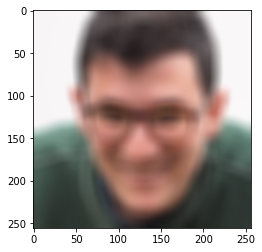

In [47]:
%matplotlib inline
gt_image = Image.open('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/gt/00000.png')
gt_image = gt_image.convert("RGB")
gt_image = gt_image.resize((256, 256))
gt_image.save(temp_path_gt)
img = np.array(gt_image)
blur = hy_blur(img,16)
plt.imshow(blur)

In [477]:
# ------------------------------------------------------
#  load image 
# ------------------------------------------------------

gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/images/00000_u'
# gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data'
img_list = os.listdir(gt_path)
img_list.sort()
len_img = len(img_list)
len_code = len(latent_code)
temp_path_data = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data/00000.png' 
temp_path_gt = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/gt/00000.png' 
# a temporary path to store generated img
l2_list = []
aldp_list=[]
ssim_list=[]
arcface_list=[]
fid_list=[]
facenet_list=[]
for i in range(len_img):
    gt_image_path_temp = gt_path+'/'+img_list[i]
    gt_image = Image.open(gt_image_path_temp)
    gt_image = gt_image.convert("RGB")
    gt_image = gt_image.resize((256, 256))
    gt_image.save(temp_path_gt)
    img = np.array(gt_image)
    
# ------------------------------------------------------
#  blur
# ------------------------------------------------------
    blur = hy_blur(img,20)
    res_image_temp = Image.fromarray(blur)
    res_image_temp.save(temp_path_data)


# ------------------------------------------------------
#  make table
# ------------------------------------------------------
    img_noise = blur
    
    l2_score = hy_L2(img,img_noise)
    l2_list.append(l2_score)

    
    aldp_score = hy_ALDp(img,img_noise)
    aldp_list.append(aldp_score)
    
    ssim_score = hy_SSIM(img,img_noise)
    ssim_list.append(ssim_score)
    
    arcface_score = hy_arcface(gt_image,res_image_temp,gt_path)
    arcface_list.append(arcface_score)
    
   
    fid_score = hy_FID()
    fid_list.append(fid_score)


    
    facenet_score = hy_facenet(temp_path_gt,temp_path_data)
    facenet_list.append(facenet_score)
    
    if i+1 == len_img:
        percent = 100.0
        print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\n')
    else:
        percent = round(1.0*i/len_img*100,2)  
        print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\r')

    
l2_avg = np.mean(l2_list)
aldp_avg = np.mean(aldp_list)
ssim_avg = np.mean(ssim_list)
arcface_avg = np.mean(arcface_list)
fid_avg = np.mean(fid_list)
facenet_avg = np.mean(facenet_list)

Processing: 100.0% [995/995]


In [478]:
print('L2:',l2_avg)
print('aldp:',aldp_avg)
print('ssim:',ssim_avg)
print('arcface:',arcface_avg)
print('fid:',fid_avg)
print('facenet:',facenet_avg)

L2: 71860.95043204991
aldp: 1.1583527786411925
ssim: 0.5808004143049994
arcface: 0.2848202727426162
fid: 276.598051040935
facenet: 1.0551431


In [53]:
# np.save('l2_blur_1k.npy',l2_list)
np.save('aldp_blur_1k.npy',aldp_list)
# np.save('ssim_blur_1k.npy',ssim_list)
# np.save('arcface_blur_1k.npy',arcface_list)
# np.save('fid_blur_1k.npy',fid_list)
# np.save('facenet_blur_1k.npy',facenet_list)

# Mosaic

In [48]:
# ------------------------------------------------------
#  test mosaic with MSapi 
# ------------------------------------------------------

# ------------------------------------------------------
#  load image 
# ------------------------------------------------------

gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/images/blur_test'
# gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data'
img_list = os.listdir(gt_path)
img_list.sort()
len_img = len(img_list)
len_code = len(latent_code)
temp_path_data = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data/00000.png' 
temp_path_gt = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/gt/00000.png' 
# a temporary path to store generated img
MSapi_list = []
for i in range(len_img):
    gt_image_path_temp = gt_path+'/'+img_list[i]
    gt_image = Image.open(gt_image_path_temp)
    gt_image = gt_image.convert("RGB")
    gt_image = gt_image.resize((256, 256))
    gt_image.save(temp_path_gt)
    img = np.array(gt_image)
    faceid1 = find_faceID(temp_path_gt)
    for j in range(9,10,1):
        mosaic = hy_mosaic(img,j)
        res_image_temp = Image.fromarray(mosaic)
        res_image_temp.save(temp_path_data)
        MSapi_score = hy_MSapi(faceid1,temp_path_data)
        MSapi_list.append(MSapi_score)
            

In [49]:
np.mean(MSapi_list)

0.37390732673267324

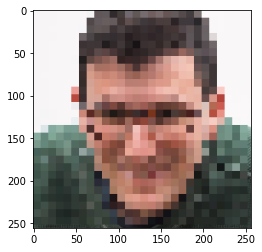

In [50]:
%matplotlib inline
gt_image = Image.open('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/gt/00000.png')
gt_image = gt_image.convert("RGB")
gt_image = gt_image.resize((256, 256))
gt_image.save(temp_path_gt)
img = np.array(gt_image)
mosaic = hy_mosaic(img,9)
plt.imshow(mosaic)

In [475]:
# ------------------------------------------------------
#  load latent and image 
# ------------------------------------------------------
latent = np.load('/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/latent_11k.npy')
latent_code = copy.copy(latent)
latent_code = np.delete(latent_code,[63,121,385,743,938],axis=0)

gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/images/00000_u'
# gt_path = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data'
img_list = os.listdir(gt_path)
img_list.sort()
len_img = len(img_list)
len_code = len(latent_code)
temp_path_data = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/data/00000.png' 
temp_path_gt = '/home/csp-uts/Hanyu/pixel2style2pixel-master/notebooks/results/ID_loss/gt/00000.png' 
# a temporary path to store generated img
l2_list = []
aldp_list=[]
ssim_list=[]
arcface_list=[]
fid_list=[]
facenet_list=[]
for i in range(len_img):
    gt_image_path_temp = gt_path+'/'+img_list[i]
    gt_image = Image.open(gt_image_path_temp)
    gt_image = gt_image.convert("RGB")
    gt_image = gt_image.resize((256, 256))
    gt_image.save(temp_path_gt)
    img = np.array(gt_image)
    
# ------------------------------------------------------
#  mosaic
# ------------------------------------------------------
    mosaic = hy_mosaic(img,8)
    res_image_temp = Image.fromarray(mosaic)
    res_image_temp.save(temp_path_data)

# ------------------------------------------------------
#  make table
# ------------------------------------------------------
    img_noise = mosaic
    
    l2_score = hy_L2(img,img_noise)
    l2_list.append(l2_score)

    
    aldp_score = hy_ALDp(img,img_noise)
    aldp_list.append(aldp_score)
    
    ssim_score = hy_SSIM(img,img_noise)
    ssim_list.append(ssim_score)
    
    arcface_score = hy_arcface(gt_image,res_image_temp,gt_path)
    arcface_list.append(arcface_score)
    
   
    fid_score = hy_FID()
    fid_list.append(fid_score)


    
    facenet_score = hy_facenet(temp_path_gt,temp_path_data)
    facenet_list.append(facenet_score)
    
    if i+1 == len_img:
        percent = 100.0
        print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\n')
    else:
        percent = round(1.0*i/len_img*100,2)  
        print('Processing: %s [%d/%d]'%(str(percent)+'%',i+1,len_img),end='\r')

    
l2_avg = np.mean(l2_list)
aldp_avg = np.mean(aldp_list)
ssim_avg = np.mean(ssim_list)
arcface_avg = np.mean(arcface_list)
fid_avg = np.mean(fid_list)
facenet_avg = np.mean(facenet_list)

Processing: 100.0% [995/995]


In [476]:
print('L2:',l2_avg)
print('aldp:',aldp_avg)
print('ssim:',ssim_avg)
print('arcface:',arcface_avg)
print('fid:',fid_avg)
print('facenet:',facenet_avg)

L2: 69817.49363721051
aldp: 1.1286692050596392
ssim: 0.587565524412694
arcface: 0.36768253999270833
fid: 371.87757833074215
facenet: 1.0342277


In [118]:
# np.save('l2_mosaic_1k.npy',l2_list)
np.save('aldp_mosaic_1k.npy',aldp_list)
# np.save('ssim_mosaic_1k.npy',ssim_list)
# np.save('arcface_mosaic_1k.npy',arcface_list)
# np.save('fid_mosaic_1k.npy',fid_list)
# np.save('facenet_mosaic_1k.npy',facenet_list)

In [67]:
arc_all_feature = np.load('arcface_all_feature_1k.npy')
arc_id_feature = np.load('arcface_identity_feature_1k.npy')
arc_blur = np.load('arcface_blur_1k.npy')
arc_mosaic = np.load('arcface_mosaic_1k.npy')